In [34]:
import pandas as pd
import numpy as np
from pathlib import Path
import pingouin as pg
from scipy import stats
import matplotlib.pyplot as plt
from __future__ import annotations   
from itertools import product  
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.multivariate.manova import MANOVA
from scipy.stats import bootstrap
from scipy.spatial import distance
from numpy.linalg import inv
from scipy.stats import chi2
import Bootstrap as bt

### Manejo que se hizo con el DataFrame original

* Se categorizó la variable MMSE de la siguiente manera:
    * 30-27 puntos: Sin deterioro
    * 26-25 puntos: Dudoso o posible deterioro
    * 24-10 puntos: Deterioro leve a moderado
    * 9-6 puntos: Demencia moderada a severa
    * Menos de 6 puntos: Demencia severa.
* Se categorizó la variable AGE en la siguiente manera:
    * 60-69 años
    * 70-79 años
    * 80-90 años


In [ ]:
df1 = pd.read_csv("Base_definitiva_2.0.csv")
pos = 0
# Agrupamiento de edades
for data in df1["Age"]:
    if data < 70:
        df1["Age"][pos] = "60-69"
    elif data >= 70 and data < 80:
        df1["Age"][pos] = "70-79"
    elif data >= 80 and data <= 90:
        df1["Age"][pos] = "80-90"
    pos += 1
df1["Age"] = df1["Age"].astype("category")

# Agrupamiento de MMSE
pos = 0
for data in df1["MMSE"]:
    if data >= 27:
        df1["MMSE"][pos] = "Sin deterioro"
    elif data >= 25 and data < 27:
        df1["MMSE"][pos] = "Posible deterioro"
    elif data >= 10 and data < 25:
        df1["MMSE"][pos] = "Deterioro leve"
    elif data >= 6 and data < 10:
        df1["MMSE"][pos] = "Deterioro moderado"
    elif data < 6:
        df1["MMSE"][pos] = "Demencia severa"
    pos += 1
df1["MMSE"] = df1["MMSE"].astype("category")
print(df1["Age"].value_counts())
print(df1["MMSE"].value_counts())

#Eliminar filas con datos faltantes
#print(len(df))
#df = df.dropna()
#print(len(df))
#print(df["Age"].value_counts())
#print(df["MMSE"].value_counts())
#df.to_csv(Path("Base_buena.csv", index=False))

Age
80-90    745
70-79    703
60-69    701
Name: count, dtype: int64
MMSE
Deterioro leve        796
Sin deterioro         693
Demencia severa       289
Deterioro moderado    237
Posible deterioro     134
Name: count, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_36344\1317753118.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df1["Age"][pos] = "70-79"
C:\Users\user\AppData\Local\Temp\ipykernel_36344\1317753118.py:8: SettingWithCopyWarning: 
A value is t

### Base de datos a usar

In [3]:
df = pd.read_csv("Base_buena.csv")

In [4]:
categoricas = ["Age","Gender","MMSE","LocationDesc"]
numericas = ["CholesterolLDL","CholesterolHDL"]

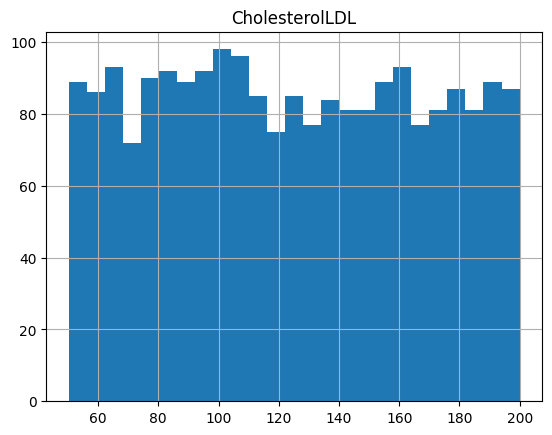

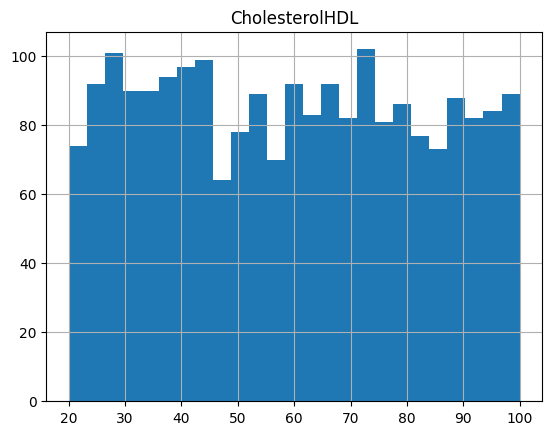

In [8]:
#[df[c].hist(bins=round(np.sqrt(len(df)))) for c in columns_interes]; plt.show()
for col in numericas:
  #df[col].hist(bins=round(np.sqrt(len(df)))); plt.title(col); plt.show()
  df[col].hist(bins=25); plt.title(col); plt.show()

In [7]:
df.corr()

ValueError: could not convert string to float: '70-79'

## Bootstrap

In [9]:
df = pd.read_csv("Base_buena.csv")
df.head()

,Unnamed: 0,Age,Gender,FamilyHistoryAlzheimers,HeadInjury,Diabetes,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,State
0,0,70-79,0,0,0,1,242.366840,56.150897,33.682564,162.189143,Sin deterioro,California
1,1,80-90,0,0,0,0,231.162595,193.407995,79.028477,294.630909,Demencia severa,Arkansas
2,2,70-79,0,1,0,0,284.181858,153.322762,69.772292,83.638324,Deterioro leve,Nebraska
3,3,70-79,1,0,0,0,159.582240,65.366637,68.457491,277.577358,Sin deterioro,Vermont
4,4,80-90,0,0,0,0,237.602184,92.869700,56.874305,291.198780,Sin deterioro,California


In [5]:
df.describe()

,Unnamed: 0,Gender,FamilyHistoryAlzheimers,HeadInjury,Diabetes,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides
count,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000
mean,1074.000000,0.506282,0.252210,0.092601,0.150768,225.197519,124.335944,59.463533,228.281496
std,620.507185,0.500077,0.434382,0.289940,0.357906,42.542233,43.366584,23.139174,101.986721
min,0.000000,0.000000,0.000000,0.000000,0.000000,150.093316,50.230707,20.003434,50.407194
25%,537.000000,0.000000,0.000000,0.000000,0.000000,190.252963,87.195798,39.095698,137.583222
50%,1074.000000,1.000000,0.000000,0.000000,0.000000,225.086430,123.342593,59.768237,230.301983
75%,1611.000000,1.000000,1.000000,0.000000,0.000000,262.031657,161.733733,78.939050,314.839046
max,2148.000000,1.000000,1.000000,1.000000,1.000000,299.993353,199.965665,99.980324,399.941862


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,2149.0,1074.000000,620.507185,0.000000,537.000000,1074.000000,1611.000000,2148.000000
Gender,2149.0,0.506282,0.500077,0.000000,0.000000,1.000000,1.000000,1.000000
FamilyHistoryAlzheimers,2149.0,0.252210,0.434382,0.000000,0.000000,0.000000,1.000000,1.000000
HeadInjury,2149.0,0.092601,0.289940,0.000000,0.000000,0.000000,0.000000,1.000000
Diabetes,2149.0,0.150768,0.357906,0.000000,0.000000,0.000000,0.000000,1.000000
CholesterolTotal,2149.0,225.197519,42.542233,150.093316,190.252963,225.086430,262.031657,299.993353
CholesterolLDL,2149.0,124.335944,43.366584,50.230707,87.195798,123.342593,161.733733,199.965665
CholesterolHDL,2149.0,59.463533,23.139174,20.003434,39.095698,59.768237,78.939050,99.980324
CholesterolTriglycerides,2149.0,228.281496,101.986721,50.407194,137.583222,230.301983,314.839046,399.941862


### ANOVA

In [27]:
F_obs, Fstar, pB, ci, resumen = bt.anova_bootstrap_stratified(
    df=df,
    formula="CholesterolLDL ~ C(State)",
    group_cols=["State"],
    B=2000,
    typ=2,
    alpha=0.10,
    seed=42,
    progress=True
)


resumen


,F_obs,p_boot,q_0.90,CI_low,CI_high
C(State),320.117218,0.851,339.291414,315.160523,342.188034


In [28]:
assert pB["C(State)"] > 0.10, "Rechazamos H0: hay diferencias significativas entre estados."

In [31]:
for col in ["CholesterolLDL", "CholesterolHDL"]:
    stat, p = stats.shapiro(df[col].dropna())
    print(f"{col}: estadístico = {stat:.4f}, p-value = {p:.4g}")
#assert p >= 0.05, f"{col} no sigue una distribución normal (p={p:.4g})"



CholesterolLDL: estadístico = 0.9536, p-value = 1.404e-25
CholesterolHDL: estadístico = 0.9527, p-value = 8.142e-26


### Estratificado

In [32]:
F_obs, Fstar, pB, ci, resumen = bt.anova_bootstrap_stratified(
    df=df,
    formula="CholesterolLDL ~ C(State)",
    group_cols=["State"],
    B=2000,
    typ=2,
    alpha=0.05,
    seed=42,
    progress=True
)


resumen


,F_obs,p_boot,q_0.95,CI_low,CI_high
C(State),320.117218,0.851,342.188034,313.045063,345.450027


### Robusto

In [36]:
# Ejemplo:
bt.plot_bootstrap_anova_robusto("C(State)", F_obs, Fstar, pB)

AttributeError: module 'Bootstrap' has no attribute 'plot_bootstrap_anova_robusto'

### MANOVA

In [30]:
# MANOVA
terms, stat_obs, pB_manova, boot_distM, resM = bt.bootstrap_manova_percentil_bca(
    df=df,
    dvs=['CholesterolLDL','CholesterolHDL'],
    formula_rhs='C(State)',
    group_cols=['State'],
    n_resamples=1500,
    method="BCa",
    seed=7
)
resM

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_resampling.py:153: RuntimeWarning: invalid value encountered in divide
  alpha_1 = ndtr(z0_hat + num1/(1 - a_hat*num1))
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_resampling.py:155: RuntimeWarning: invalid value encountered in divide
  alpha_2 = ndtr(z0_hat + num2/(1 - a_hat*num2))
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\_lib\_util.py:352: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


BootstrapResult(confidence_interval=ConfidenceInterval(low=array([       nan, 0.11771966, 7.02053517, 6.97331491]), high=array([       nan, 0.12023249, 7.4617791 , 7.46399043])), bootstrap_distribution=array([[0.93989954, 0.92625854, 0.92449584, ..., 0.93171892, 0.92688421,
        0.91730123],
       [0.11154385, 0.11480208, 0.11248736, ..., 0.11096669, 0.1124214 ,
        0.11466859],
       [7.5038898 , 7.35297943, 7.56111165, ..., 7.62704273, 7.54547617,
        7.44198232],
       [7.44191729, 7.30401122, 7.51737612, ..., 7.57626966, 7.49885203,
        7.40432842]], shape=(4, 1500)), standard_error=array([0.00792879, 0.0025646 , 0.18529911, 0.18530232]))